In [47]:
# from google.colab import drive
# drive.mount('/content/drive')

In [48]:
# !ls

In [5]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D 


sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [7]:
os.system('whereis python')

python: /usr/bin/python /home/svupper/.cache/pypoetry/virtualenvs/kaggle-flowers-classification-keras-q23kQ_ea-py3.10/bin/python /usr/share/man/man1/python.1.gz


0

## Load data

#### Extract files from zip file

In [8]:
zip_ref = zipfile.ZipFile('flowers.zip', 'r')
zip_ref.extractall('unzipped_folder') # unzip directory
zip_ref.close()

In [9]:
# base_path = 'Dataset/flowers/'
base_path = 'unzipped_folder/flowers/'
# daisy：菊花。 dandelion：蒲公英。 rose：玫瑰。 sunflower：向日葵。 tulip：郁金香。
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

#### Load file names

In [10]:
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [11]:
print('length for each category:', [len(f) for f in fnames])

length for each category: [764, 1052, 784, 733, 984]


#### Load images

In [12]:
# train, test = train_test_split(fnames[0], train_size=0.8)
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

In [13]:
print('number of images for each category:', [len(f) for f in images])

number of images for each category: [764, 1052, 784, 733, 984]


#### Calculate the minimal shape for all images

In [14]:
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))

134,134 is the min shape for daisy
98,134 is the min shape for dandelion
80,150 is the min shape for rose
134,152 is the min shape for sunflower
134,134 is the min shape for tulip


#### Create a function to convert cv2 BGR format to RGB for showing

In [15]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

#### Show sample images for all flowers

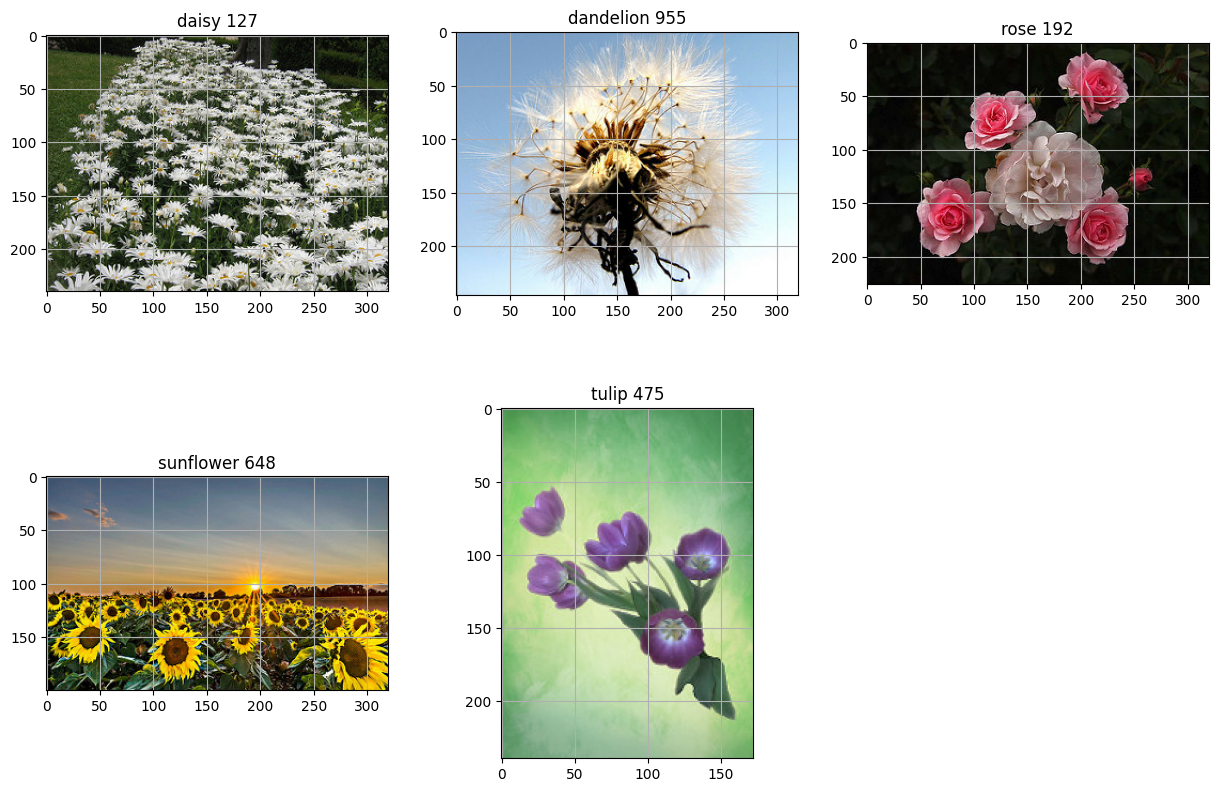

In [16]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()

#### Resize all the images to 256x256

(240, 240, 3)
(256, 256, 3)


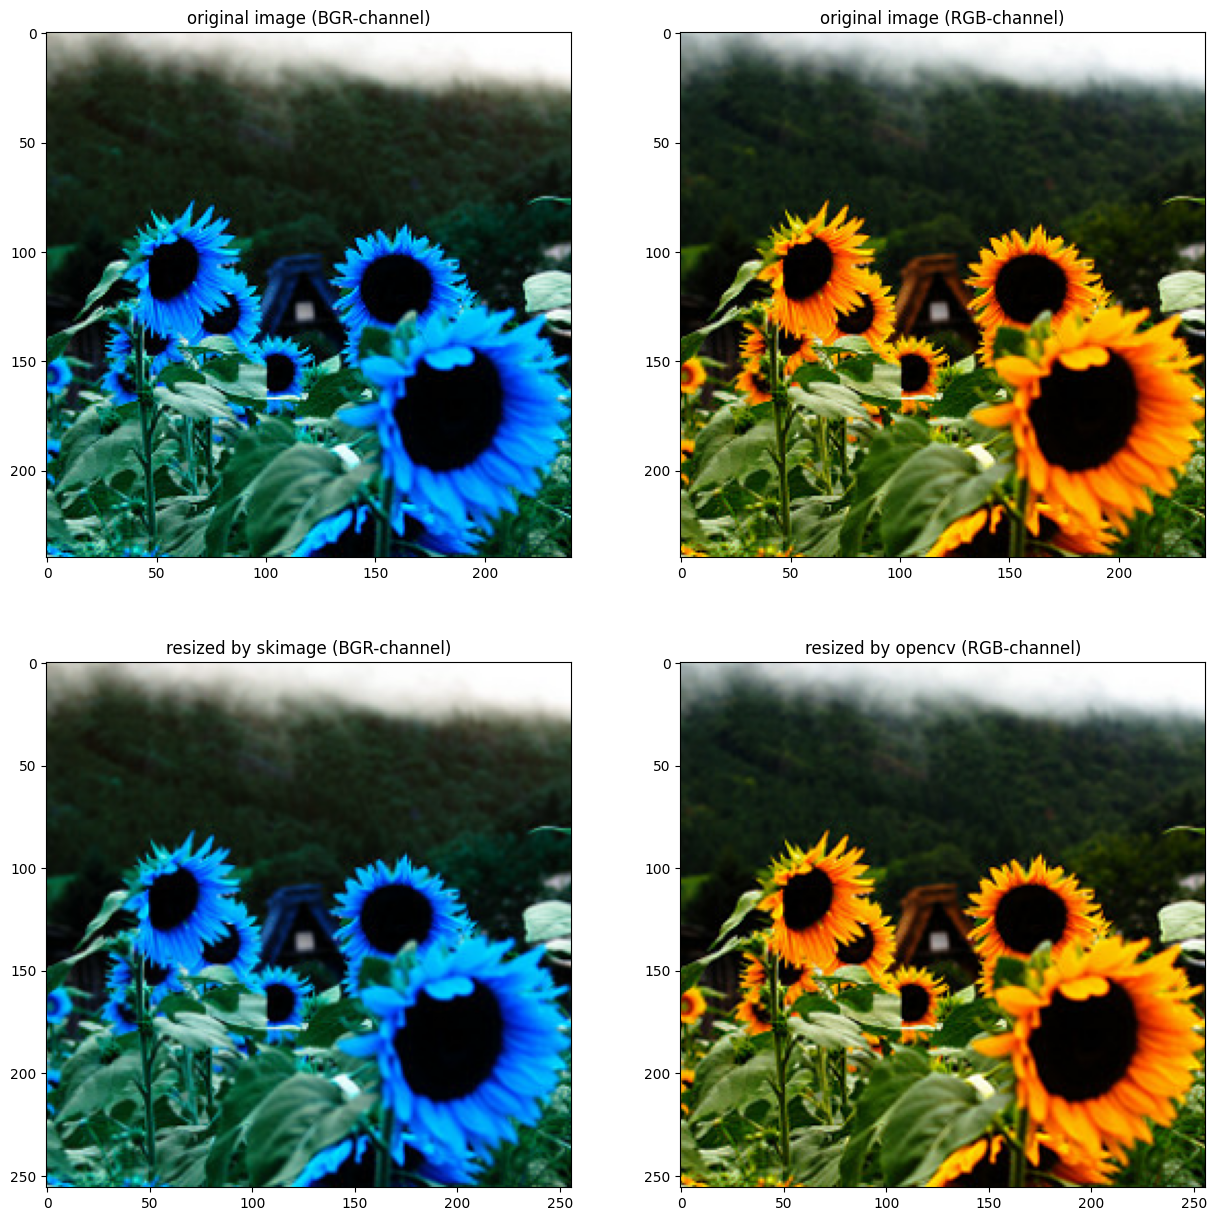

In [17]:
img_width, img_height = 256, 256

img = images[3][659]
print(img.shape)
resized_img = resize(img, (img_width, img_height, 3))
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)
print(resized_img.shape)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('original image (BGR-channel)')
plt.grid(False)
plt.imshow(img)
plt.subplot(2,2,2)
plt.title('original image (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(img))
plt.subplot(2,2,3)
plt.title('resized by skimage (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))
plt.subplot(2,2,4)
plt.title('resized by opencv (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(resized_img2))
plt.show()

In [18]:
# Apply resize to all images
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

#### Split dataset to 80% of training and 20% of validation 

In [19]:
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

#### Creat labels

In [20]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[611, 841, 627, 586, 787]
sum of train images: 3452
[153, 211, 157, 147, 197]
sum of val_images: 865


<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_3185757/935631959.py:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i is 0:
/tmp/ipykernel_3185757/935631959.py:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i is 0:


#### Convert image data to numpy array
Convert and pre-processing

convert class labels to binary class labels

In [21]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [22]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)

Before converting
train data: (3452, 256, 256, 3)
train labels: (3452,)

After converting
train data: (3452, 256, 256, 3)
train labels: (3452, 5)


#### Shuffle the dataset (set a seed and randomize both the data and the labels)

In [23]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [24]:
train_data = train_data[:3400]
train_labels = train_labels[:3400]
val_data = val_data[:860]
val_labels = val_labels[:860]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)

shape of train data: (3400, 256, 256, 3)
shape of train labels: (3400, 5)
shape of val data: (860, 256, 256, 3)
shape of val labels: (860, 5)


## Build the model

In [69]:
WEIGHTS_PATH_NO_TOP = 'drive/My Drive/AI/My_Model/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [25]:
WEIGHTS_PATH_NO_TOP = None #'models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [26]:
def create_model_from_scratch():

    """
     train from scratch
    """
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=train_data.shape[1:], activation='relu', name='conv_1'))
    model.add(Conv2D(32, (3,3), activation='relu', name='conv_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_1'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'))
    model.add(Conv2D(64, (3,3), activation='relu', name='conv_4'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_2'))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'))
    model.add(Conv2D(128, (3,3), activation='relu', name='conv_6'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_3'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='dense_1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', name='dense_2'))
    model.add(Dense(len(categories), name='output'))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [27]:
def create_model_from_VGG19():
    """
      use VGG19
    """
    model = VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
    
    # Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
    for layer in model.layers[:1]:
      layer.trainable = False
      
    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(len(categories), activation="softmax")(x)
    
    # creating the final model 
    final_model = Model(inputs = model.input, outputs = predictions)
    
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return final_model

In [32]:
from tensorflow import keras
def create_model_from_ResNet50():

    """
     Use ResNet-50 (this model's code is from https://www.kaggle.com/cokastefan/keras-resnet-50)
    """
    model = Sequential()
    model.add(keras.Input(shape=(240, 240, 3)))
    model.add(ResNet50(include_top=False, pooling='avg', weights=WEIGHTS_PATH_NO_TOP))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(len(categories), activation='softmax'))

    model.layers[0].trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [29]:
model_scratch = create_model_from_scratch()
model_scratch.summary()

/home/svupper/.cache/pypoetry/virtualenvs/kaggle-flowers-classification-keras-q23kQ_ea-py3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-01 11:08:43.882832: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 235929600 exceeds 10% of free system memory.
2024-07-01 11:08:43.983404: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 235929600 exceeds 10% of free system memory.
2024-07-01 11:08:44.233331: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 235929600 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 254, 254, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 127, 127, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 60, 60, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,336,229 (226.35 MB)

 Trainable params: 59,336,229 (226.35 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_VGG19 = create_model_from_VGG19()
model_VGG19.summary()

2024-07-01 11:12:11.076317: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2024-07-01 11:12:11.214218: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             

 Total params: 54,634,565 (208.41 MB)

 Trainable params: 54,634,565 (208.41 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# import keras
# def create_model_from_ResNet50():
#     return keras.applications.ResNet50(
#         include_top=True,
#         weights="imagenet",
#         input_tensor=None,
#         input_shape=None,
#         pooling=None,
#         classes=1000,
#         classifier_activation="softmax",
#     )

In [33]:
model_ResNet50 = create_model_from_ResNet50()
model_ResNet50.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,907,845 (114.09 MB)

 Trainable params: 6,309,893 (24.07 MB)

 Non-trainable params: 23,597,952 (90.02 MB)

## Prepare input data

In [34]:
# Parameters
batch_size = 32
epochs1 = 50
epochs2 = 10
epochs3 = 30

#### Create generator

In [35]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

## Train the model

#### Fit the model with generator

In [39]:
start = time.time()

model_scratch_info = model_scratch.fit(
    # generator=train_generator, 
    train_data, train_labels,
    # steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs1, 
    # validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    # validation_data=val_generator, 
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_scratch took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs1) )

Epoch 1/50
107/107 - 542s - 5s/step - acc: 0.2288 - loss: 13.4106
Epoch 2/50
107/107 - 545s - 5s/step - acc: 0.2526 - loss: 1.5957
Epoch 3/50
107/107 - 654s - 6s/step - acc: 0.2803 - loss: 1.5729
Epoch 4/50
107/107 - 515s - 5s/step - acc: 0.3171 - loss: 1.5310
Epoch 5/50
107/107 - 473s - 4s/step - acc: 0.3703 - loss: 1.4437
Epoch 6/50
107/107 - 470s - 4s/step - acc: 0.4682 - loss: 1.2852
Epoch 7/50
107/107 - 469s - 4s/step - acc: 0.5371 - loss: 1.1441
Epoch 8/50
107/107 - 468s - 4s/step - acc: 0.6141 - loss: 0.9607
Epoch 9/50
107/107 - 468s - 4s/step - acc: 0.6685 - loss: 0.8635
Epoch 10/50
107/107 - 502s - 5s/step - acc: 0.7206 - loss: 0.7356
Epoch 11/50
107/107 - 472s - 4s/step - acc: 0.7738 - loss: 0.5860
Epoch 12/50
107/107 - 472s - 4s/step - acc: 0.8068 - loss: 0.5225
Epoch 13/50
107/107 - 472s - 4s/step - acc: 0.8438 - loss: 0.4234
Epoch 14/50
107/107 - 472s - 4s/step - acc: 0.8541 - loss: 0.4329
Epoch 15/50


KeyboardInterrupt: 

In [ ]:
start = time.time()

model_VGG19_info = model_VGG19.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs2, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator,
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_VGG19 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs2) )

Epoch 1/10
 - 174s - loss: 1.7788 - acc: 0.2401 - val_loss: 1.5995 - val_acc: 0.2442
Epoch 2/10


In [82]:
from keras.optimizers import Adam
model_ResNet50.compile(optimizer=Adam(learning_rate=0.0005), loss="mae")

In [88]:
start = time.time()

model_ResNet50_info = model_ResNet50.fit(
    train_data, train_labels,
    
    # steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs3, 
    # validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    # validation_data=val_generator, 
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_ResNet50 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs3) )

Epoch 1/30


ValueError: Input 0 of layer "resnet50" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 256, 256, 3)

In [40]:
def return_name(label_arr):
  idx = np.where(label_arr == 1)
  return idx[0][0]

In [ ]:
# plt.figure(figsize=(15,15))
# # indexs = [10, 20, 30, 40, 50, 60, ]
# for i in range(9):
#   idx = np.random.randint(860)
#   plt.subplot(3,3,i+1)
#   plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
#   category_idx = return_name(val_labels[idx])
#   plt.title(categories[category_idx])
#   plt.grid('off')
# plt.show()

## Predict and evaluate the model

In [41]:
# Plots for training and testing process: loss and accuracy

def plot_model_history(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
  plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  
  plt.show()

In [42]:
plot_model_history('model_scratch', model_scratch_info.history, epochs1)
# plot_model_history('model_VGG19', model_VGG19_info.history, epochs2)
# plot_model_history('model_ResNet50', model_ResNet50_info.history, epochs3)

NameError: name 'model_scratch_info' is not defined

#### Predict one image

In [ ]:
def predict_one_image(img, model):
  img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
  img = np.reshape(img, (1, img_width, img_height, 3))
  img = img/255.
  pred = model.predict(img)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

rose 92%


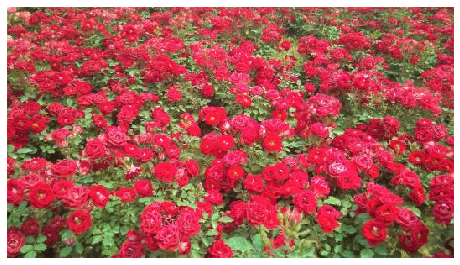

In [200]:
# idx = 120
# pred, probability = predict_one_image(images[4][idx], model_ResNet50)

test_img = cv2.imread('drive/My Drive/AI/Dataset/test_images/rose1.jpg')
pred, probability = predict_one_image(test_img, model_ResNet50)
print('%s %d%%' % (categories[pred], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()

In [ ]:
def predict_val(val_data, model):
  val_input = np.reshape(val_data, (1, img_width, img_height, 3))
  val_input = val_input/255.
  pred = model.predict(val_input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

Model trained from ResNet-50


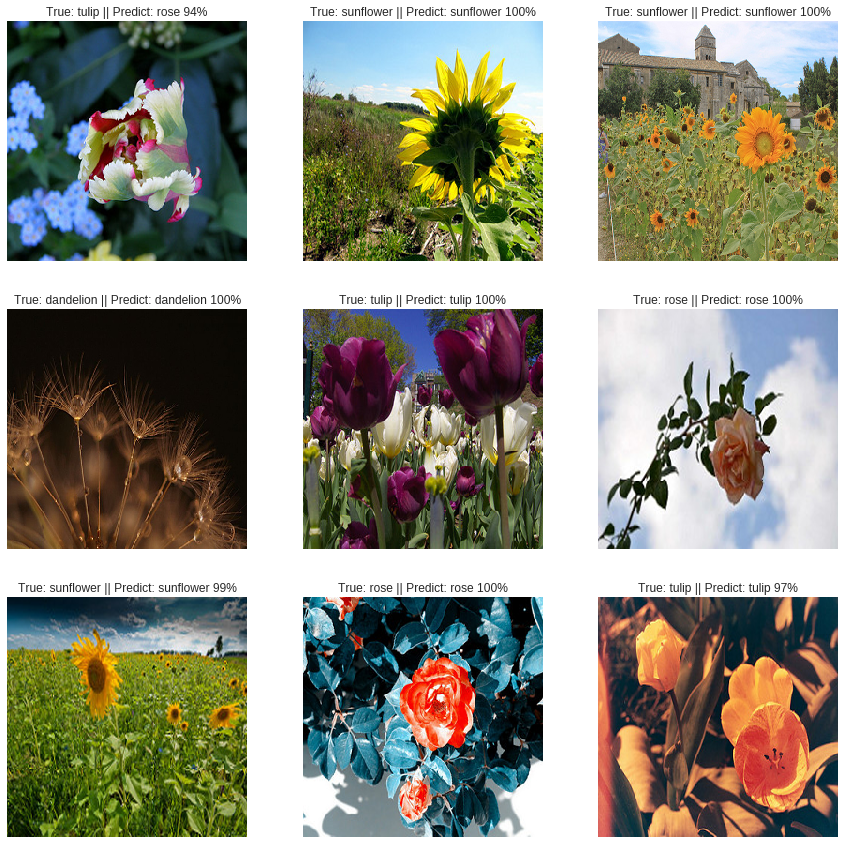

In [202]:
print("Model trained from ResNet-50")
plt.figure(figsize=(15,15))
for i in range(9):
  
  idx = np.random.randint(860)
  
  ax = plt.subplot(3,3,i+1)
  plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
  category_idx = return_name(val_labels[idx])
  
  pred, prob = predict_val(val_data[idx], model_ResNet50)
  plt.title('True: %s || Predict: %s %d%%' % (categories[category_idx], categories[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  
plt.show()

In [ ]:
model_ResNet50.save('drive/My Drive/AI/My_Model/flowers_classification_pretrained_by_resnet50_acc_92.h5')